# Subset Selection problem using LASSO

In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import accuracy_score, mean_squared_error, r2_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression, Lasso



## Dataset
Here ive used dataset of classification of brain stroke from kaggle
link: https://www.kaggle.com/datasets/fedesoriano/stroke-prediction-dataset/code

In [3]:
df = pd.read_csv('healthcare-dataset-stroke-data.csv')
df.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


In [4]:
df.describe()

,id,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke
count,5110.000000,5110.000000,5110.000000,5110.000000,5110.000000,4909.000000,5110.000000
mean,36517.829354,43.226614,0.097456,0.054012,106.147677,28.893237,0.048728
std,21161.721625,22.612647,0.296607,0.226063,45.283560,7.854067,0.215320
min,67.000000,0.080000,0.000000,0.000000,55.120000,10.300000,0.000000
25%,17741.250000,25.000000,0.000000,0.000000,77.245000,23.500000,0.000000
50%,36932.000000,45.000000,0.000000,0.000000,91.885000,28.100000,0.000000
75%,54682.000000,61.000000,0.000000,0.000000,114.090000,33.100000,0.000000
max,72940.000000,82.000000,1.000000,1.000000,271.740000,97.600000,1.000000


In [5]:
df.isnull().sum().sort_values(ascending=False)

bmi                  201
id                     0
gender                 0
age                    0
hypertension           0
heart_disease          0
ever_married           0
work_type              0
Residence_type         0
avg_glucose_level      0
smoking_status         0
stroke                 0
dtype: int64

There are 201 samples with no values in bmi, for better result we drop them

In [6]:
df.dropna(inplace=True)

Here ive used label encoder to encode factors like gender, marriage status and residence type

In [7]:
# label encoding
LabelEncoder = LabelEncoder()
df['gender'] = LabelEncoder.fit_transform(df['gender'])
df['ever_married'] = LabelEncoder.fit_transform(df['ever_married'])
df['Residence_type'] = LabelEncoder.fit_transform(df['Residence_type'])
df.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,1,67.0,0,1,1,Private,1,228.69,36.6,formerly smoked,1
2,31112,1,80.0,0,1,1,Private,0,105.92,32.5,never smoked,1
3,60182,0,49.0,0,0,1,Private,1,171.23,34.4,smokes,1
4,1665,0,79.0,1,0,1,Self-employed,0,174.12,24.0,never smoked,1
5,56669,1,81.0,0,0,1,Private,1,186.21,29.0,formerly smoked,1


Here ive used one hot encoder to encode factors like work type and smoking status

In [8]:
categorical2=['work_type', 'smoking_status']
df = pd.get_dummies(df, columns=categorical2, drop_first=True).astype('int64')
df.head()

,id,gender,age,hypertension,heart_disease,ever_married,Residence_type,avg_glucose_level,bmi,stroke,work_type_Never_worked,work_type_Private,work_type_Self-employed,work_type_children,smoking_status_formerly smoked,smoking_status_never smoked,smoking_status_smokes
0,9046,1,67,0,1,1,1,228,36,1,0,1,0,0,1,0,0
2,31112,1,80,0,1,1,0,105,32,1,0,1,0,0,0,1,0
3,60182,0,49,0,0,1,1,171,34,1,0,1,0,0,0,0,1
4,1665,0,79,1,0,1,0,174,24,1,0,0,1,0,0,1,0
5,56669,1,81,0,0,1,1,186,29,1,0,1,0,0,1,0,0


In [9]:
df.describe()

,id,gender,age,hypertension,heart_disease,ever_married,Residence_type,avg_glucose_level,bmi,stroke,work_type_Never_worked,work_type_Private,work_type_Self-employed,work_type_children,smoking_status_formerly smoked,smoking_status_never smoked,smoking_status_smokes
count,4909.000000,4909.000000,4909.000000,4909.000000,4909.000000,4909.000000,4909.000000,4909.000000,4909.000000,4909.000000,4909.000000,4909.000000,4909.000000,4909.000000,4909.000000,4909.000000,4909.000000
mean,37064.313506,0.410063,42.854145,0.091872,0.049501,0.652679,0.507232,104.816052,28.448564,0.042575,0.004482,0.572622,0.157873,0.136688,0.170503,0.377266,0.150132
std,20995.098457,0.492309,22.575986,0.288875,0.216934,0.476167,0.499999,44.417384,7.843834,0.201917,0.066801,0.494748,0.364659,0.343552,0.376113,0.484752,0.357238
min,77.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,55.000000,10.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,18605.000000,0.000000,25.000000,0.000000,0.000000,0.000000,0.000000,77.000000,23.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,37608.000000,0.000000,44.000000,0.000000,0.000000,1.000000,1.000000,91.000000,28.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,55220.000000,1.000000,60.000000,0.000000,0.000000,1.000000,1.000000,113.000000,33.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000
max,72940.000000,2.000000,82.000000,1.000000,1.000000,1.000000,1.000000,271.000000,97.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4909 entries, 0 to 5109
Data columns (total 17 columns):
 #   Column                          Non-Null Count  Dtype
---  ------                          --------------  -----
 0   id                              4909 non-null   int64
 1   gender                          4909 non-null   int64
 2   age                             4909 non-null   int64
 3   hypertension                    4909 non-null   int64
 4   heart_disease                   4909 non-null   int64
 5   ever_married                    4909 non-null   int64
 6   Residence_type                  4909 non-null   int64
 7   avg_glucose_level               4909 non-null   int64
 8   bmi                             4909 non-null   int64
 9   stroke                          4909 non-null   int64
 10  work_type_Never_worked          4909 non-null   int64
 11  work_type_Private               4909 non-null   int64
 12  work_type_Self-employed         4909 non-null   int64
 13  work_typ

In [11]:
x = df.drop(["stroke"], axis=1)
y = df["stroke"]

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2)

In [12]:
model = LogisticRegression()

In [13]:
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)



In [14]:
x_test = scaler.transform(x_test)

## Lasso regression

$$ sum of squared residuals +  λ * |slope| $$     
Lasso regression is a regularization technique. It is used over regression methods for a more accurate prediction. This model uses shrinkage. Shrinkage is where data values are shrunk towards a central point as the mean.

How Lasso Regression Works for Feature Selection:  
1. Regularization Technique: Lasso adds a penalty term to the standard linear regression cost function, which is proportional to the absolute value of the coefficients multiplied by a regularization parameter (alpha or lambda).

2. Shrinking Coefficients: The key aspect of Lasso is that it penalizes the sum of the absolute magnitudes of the coefficients. During the optimization process, it tends to shrink some coefficients all the way to zero, effectively eliminating some features by making their corresponding coefficients zero.

3. Sparsity and Feature Selection: Lasso's penalty term has a geometrical shape that intersects with the contour lines of the least squares objective at the axes. This geometric shape induces a 'sparsity' effect, leading to intersections at zero values on the coefficient axes. As a result, Lasso tends to favor solutions where some coefficients become exactly zero, effectively performing feature selection.

4. Balance between Fit and Simplicity: The strength of the regularization parameter alpha determines the degree of shrinkage applied to the coefficients. Larger values of alpha lead to more coefficients being pushed to zero, thus enhancing the sparsity of the model. This parameter allows controlling the trade-off between fitting the data well and keeping the model simple.

In [16]:
def select_features_lasso(x_train, y_train, x_test, alpha=1.0):
    model = LogisticRegression(penalty='l1', solver='liblinear', C=1/alpha, max_iter=1000, random_state=42)
    model.fit(x_train, y_train)
    selected_features = model.coef_[0] != 0
    selected_indices = [i for i, x in enumerate(selected_features) if x]
    # selected_feature_names = x_train.columns[selected_indices]
    x_train_sel = x_train[:, selected_features]
    x_test_sel = x_test[:, selected_features]
    return x_train_sel, x_test_sel, selected_features

In [17]:
x_train_sel, x_test_sel, selected_indices = select_features_lasso(x_train, y_train, x_test, alpha=0.01)
model_selected_features = LogisticRegression(max_iter=1000, random_state=42)
model_selected_features.fit(x_train_sel, y_train)



LogisticRegression(max_iter=1000, random_state=42)

In [25]:
y_pred = model_selected_features.predict(x_test_sel)
accuracy_selected = accuracy_score(y_test, y_pred)
mse_f = mean_squared_error(y_test, y_pred)
r2_f = r2_score(y_test, y_pred)
print(f"Accuracy score selected features is {accuracy_selected:.2f}")


Accuracy score selected features is 0.96


In [19]:
names = df.drop(["stroke"], axis=1).columns
print(names.values)

['id' 'gender' 'age' 'hypertension' 'heart_disease' 'ever_married'
 'Residence_type' 'avg_glucose_level' 'bmi' 'work_type_Never_worked'
 'work_type_Private' 'work_type_Self-employed' 'work_type_children'
 'smoking_status_formerly smoked' 'smoking_status_never smoked'
 'smoking_status_smokes']


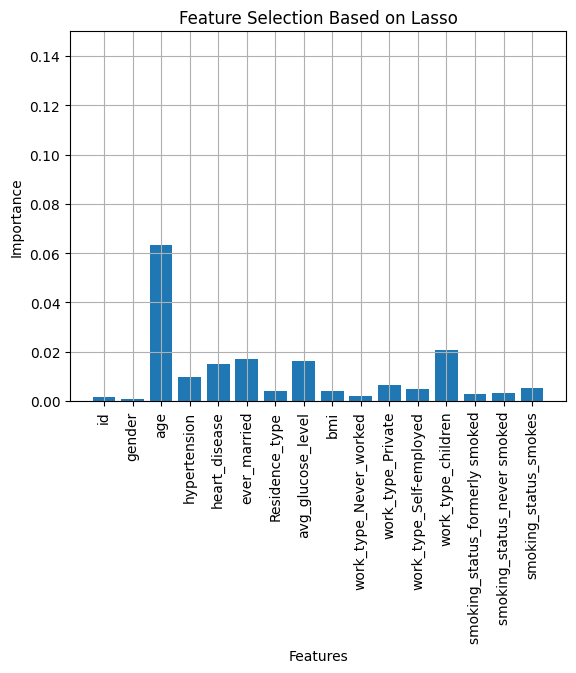

In [20]:
lasso1 = Lasso(alpha=0.00001)
lasso1.fit(x_train, y_train)

# Using np.abs() to make coefficients positive.  
lasso1_coef = np.abs(lasso1.coef_)

# plotting the Column Names and Importance of Columns. 
plt.bar(names, lasso1_coef)
plt.xticks(rotation=90)
plt.grid()
plt.title("Feature Selection Based on Lasso")
plt.xlabel("Features")
plt.ylabel("Importance")
plt.ylim(0, 0.15)
plt.show()